In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from folium.plugins import TimestampedGeoJson
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('../data/starbucks.csv')

country = 'CA'
city = 'Toronto'
features = ['City', 'Street Address', 'Longitude', 'Latitude']

df = df[(df['Country'] == country) & (df['City'] == city)][features].reset_index(drop=True).rename(columns={'Longitude': 'x', 'Latitude': 'y'}).copy()

df['color'] = 'red'
df.loc[1, 'color'] = 'blue'

df = df.head(50)


In [3]:
start = df.loc[1, ['y', 'x']]

m = folium.Map(
    location=start,
    tiles='cartodbpositron',
    zoom_start=12
)

df.apply(
    lambda row: folium.CircleMarker(
        location=[row['y'], row['x']],
        radius = 5,
        color=row['color'],
        fill=True,
    ).add_to(m),
    axis=1
)

m


/Users/alex/Projects/Route_Optimization/.venv/lib/python3.11/site-packages/folium/utilities.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


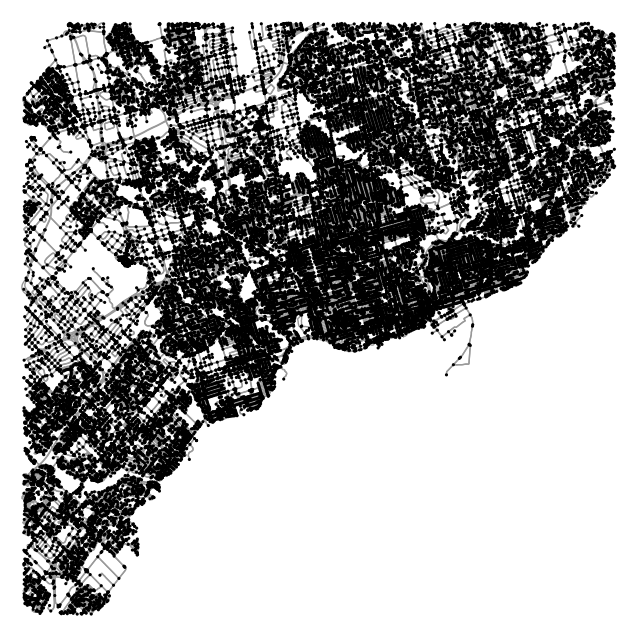

In [4]:
G = ox.graph_from_point(start, dist=20000, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor='white', node_size=5, node_color='black')


In [5]:
lat = float(df.loc[1, 'y'])
lon = float(df.loc[1, 'x'])
start = (lat, lon)

start_node = ox.distance.nearest_nodes(G, lon, lat)
df['node'] = df.apply(lambda row: ox.distance.nearest_nodes(G, row['x'], row['y']), axis=1)
df = df.drop_duplicates('node', keep='first')
df.head()

,City,Street Address,x,y,color,node
0,Toronto,66 Gerrard Street East,-79.38,43.66,red,34404231
1,Toronto,2201 Dundas Street West,-79.45,43.65,blue,21436459
2,Toronto,5251 Dundas Street West,-79.54,43.64,red,50315756
3,Toronto,1 King's College Circle,-79.40,43.66,red,24959558
4,Toronto,250 Queen Street West,-79.39,43.65,red,29696849


In [6]:
# find shortest path bewteen 2 nodes

def f(a, b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    
    return d

distance_matrix = np.asarray([[f(a,b) for b in df['node'].tolist()] for a in df['node'].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=df['node'].values, index=df['node'].values).round().astype('int')

distance_matrix.head()

,34404231,21436459,50315756,24959558,29696849,29687653,60946104,261644001,4472746302,49416372,...,361006898,21436518,264994802,148329114,2399493053,261656721,244447778,270401014,25628773,252354464
34404231,0,567,896,184,180,147,237,791,996,622,...,1339,99,708,564,1100,762,613,956,153,821
21436459,566,0,621,416,474,535,634,975,1402,658,...,1064,467,992,1003,825,948,897,1361,510,598
50315756,920,644,0,845,790,811,1059,953,1392,917,...,598,892,1268,1323,359,938,1173,1351,786,833
24959558,184,434,849,0,166,226,291,834,1123,486,...,1292,85,832,684,1053,733,737,1083,314,679
29696849,182,474,773,154,0,76,339,888,1104,640,...,1217,113,720,713,977,787,624,1063,164,833


In [7]:
drivers   = 1   # assume we have 1 driver only
lst_nodes = df['node'].tolist()

print(f"Start point: {start_node}, visiting {len(lst_nodes)} locations")

depot_index = lst_nodes.index(start_node)

manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, depot_index)
model   = pywrapcp.RoutingModel(manager)

def get_distance(from_index, to_index):
    from_user_index = manager.IndexToNode(from_index)
    to_user_index = manager.IndexToNode(to_index)
    from_node_id = lst_nodes[from_user_index]
    to_node_id   = lst_nodes[to_user_index]
    return int(distance_matrix.loc[from_node_id, to_node_id])

distance_callback = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance_callback)

params = pywrapcp.DefaultRoutingSearchParameters()
params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

solution = model.SolveWithParameters(params)
if not solution:
    raise RuntimeError("No solution found")


index          = model.Start(0)
route_index    = []
route_distance = 0

while not model.IsEnd(index):
    user_idx = manager.IndexToNode(index)
    route_index.append(lst_nodes[user_idx])

    previous_index = index
    index = solution.Value(model.NextVar(index))

    route_distance += get_distance(previous_index, index)

print("Route:", route_index)
print(f"Total distance: {round(route_distance/1000, 2)}km")
print(f"Nodes visited: {len(route_index)}")


Start point: 21436459, visiting 33 locations
Route: [21436459, 50315756, 2399493053, 361006898, 1460725899, 248493797, 261656721, 261644001, 429564841, 279616151, 148329114, 108447868, 277650773, 244447778, 264994802, 4472746302, 270401014, 29657729, 252354464, 49416372, 58405203, 60946104, 25628935, 20964581, 24959558, 21436518, 34404231, 25628773, 29687653, 29696849, 273320292, 2887796942, 221833301]
Total distance: 9.62km
Nodes visited: 33


In [8]:
def get_path(route_index):
    lst_paths = []
    for i in range(len(route_index)):
        try:
            a, b = route_index[i], route_index[i+1]
        except:
            break

        try:
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')

            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue

    return lst_paths


lst_paths = get_path(route_index)


total_milage = 0
for path in lst_paths:
    for u, v in zip(path[:-1], path[1:]):
        edge_data_dict = G.get_edge_data(u, v)
        lengths = [edata['length'] for edata in edge_data_dict.values()]
        total_milage += min(lengths)

    coords = []
    for node_id in path:
        node_data = G.nodes[node_id]
        coords.append((node_data['y'], node_data['x']))
    folium.PolyLine(locations=coords, color="blue", weight=2).add_to(m)

start_node_id = route_index[0]
end_node_id = route_index[-1]
folium.CircleMarker(
    location=[G.nodes[start_node_id]['y'], G.nodes[start_node_id]['x']],
    radius=5,
    color="green",
    fill=True,
    fill_color="green",
    popup="Start"
).add_to(m)
folium.CircleMarker(
    location=[G.nodes[end_node_id]['y'], G.nodes[end_node_id]['x']],
    radius=5,
    color="red",
    fill=True,
    fill_color="red",
    popup="End"
).add_to(m)

total_milage = total_milage / 1000.0
print(f"Total milage: {total_milage:.2f} km")

m


Total milage: 143.98 km


In [9]:
features = []
start_time = datetime.now()

dt = timedelta(seconds=5)

for step, node_id in enumerate(route_index):
    lat = G.nodes[node_id]['y']
    lon = G.nodes[node_id]['x']
    timestamp = (start_time + step * dt).isoformat()

    feature = {
        "type": "Feature",
        "properties": {
            "time": timestamp,
            "popup": f"Step {step+1}: Node {node_id}"
        },
        "geometry": {
            "type": "Point",
            "coordinates": [lon, lat]
        }
    }
    features.append(feature)

geojson = {
    "type": "FeatureCollection",
    "features": features
}

TimestampedGeoJson(
    data=geojson,
    transition_time=500,
    period="PT5S",
    add_last_point=True,
    auto_play=True,
    loop=False,
).add_to(m)

m
